# 1. Preliminaries

## 1.1. Load dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import datetime
import dill
%matplotlib inline

/Users/alomana/anaconda3/envs/py2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/Users/alomana/anaconda3/envs/py2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess


In [2]:
import miner

## 1.2. Define results directory

In [3]:
# create name for results folder where output files will be saved
resultsFolder = "results.demo"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

# 2. Load expression data

In [4]:
dataFile='/Volumes/omics4tb2/jpark/Projects/PD_GSC_pstat/Results/scRNA_seq/10X_chromium/SN520_pstat_2019.01.30/MINER/data/expressionData.csv'
expressionData=pd.read_csv(dataFile,index_col=0,header=0)

# 3. Pre-process expression data

In [5]:
expressionData, conversionTable = miner.identifierConversion(expressionData)
expressionData = miner.zscore(expressionData)

miner.py:100: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  idMap = pd.read_table(conversionTable)


completed identifier conversion.
16216 genes were converted.


# 4. Set single-cell network inference parameters

In [25]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.05 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 4 #bulk RNAseq default=5;single cell RNAseq default=4

# number of cores available for multiprocessing
numCores = 4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# 5. Network inference

## 5.1. Co-expression clustering

In [28]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

t_start = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-04-25 20:59:53
0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 188.34 minutes
Number of genes clustered: 4856
Number of unique clusters: 465
2019-04-26 00:11:49


In [44]:
# visualize first 10 clusters
plt.figure(figsize=(8,8))
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in np.arange(10).astype(str)]),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 10 clusters",FontSize=20)

KeyError: u"None of [Index([u'ENSG00000122483', u'ENSG00000175063', u'ENSG00000100526',\n       u'ENSG00000111665', u'ENSG00000162063', u'ENSG00000135476',\n       u'ENSG00000024526', u'ENSG00000092853', u'ENSG00000157456',\n       u'ENSG00000088325',\n       ...\n       u'ENSG00000113387', u'ENSG00000203667', u'ENSG00000166595',\n       u'ENSG00000159199', u'ENSG00000117632', u'ENSG00000143933',\n       u'ENSG00000163170', u'ENSG00000129235', u'ENSG00000131148',\n       u'ENSG00000111786'],\n      dtype='object', length=599)] are in the [index]"

<Figure size 576x576 with 0 Axes>

Text(0,0.5,'Number of clusters')

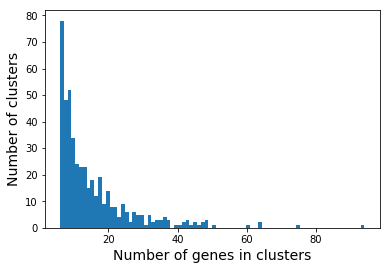

In [33]:
# plot histogram of the cluster size distribution
plt.figure()
counts_ = plt.hist([len(revisedClusters[key]) for key in revisedClusters.keys()],bins=80)
plt.xlabel("Number of genes in clusters",FontSize=14)
plt.ylabel("Number of clusters",FontSize=14)

## 5.2 Mechanistic inference

In [35]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("discovered {:d} unique regulators and {:d} unique co-regulated genes".format(len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-04-26 00:23:51
Running mechanistic inference
completed mechanistic inference in 5.59 minutes
discovered 190 unique regulators and 3313 unique co-regulated genes
2019-04-26 00:29:26


## 5.3. Infer bicluster membership

In [36]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-04-26 00:29:35
done!
done!
done!
done!
completed patient mapping in 430.97 minutes
2019-04-26 07:40:33


## 5.4. Infer subtypes

2019-04-26 07:40:34
done!
completed subtype inference in 39.52 minutes
2019-04-26 08:20:05


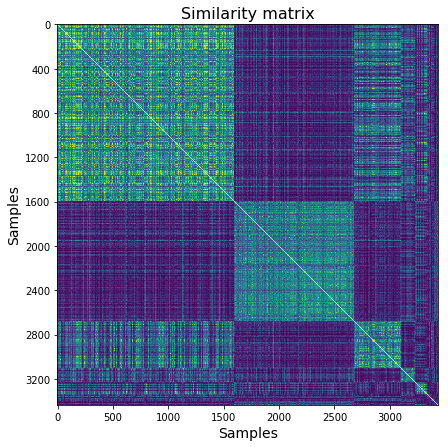

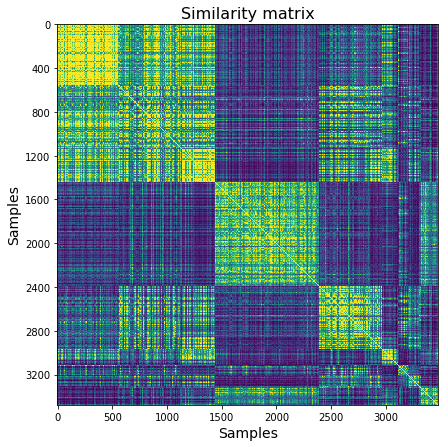

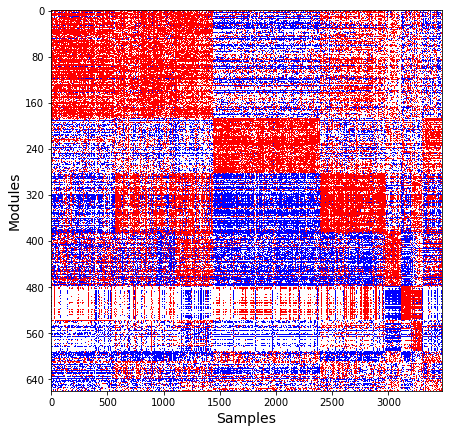

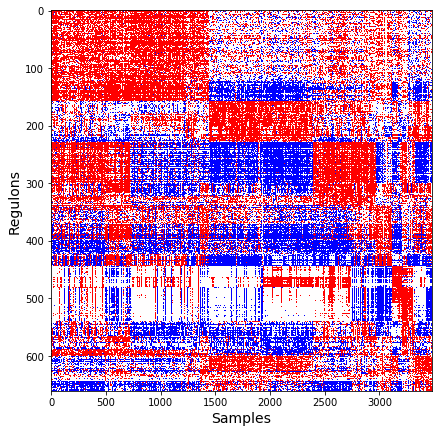

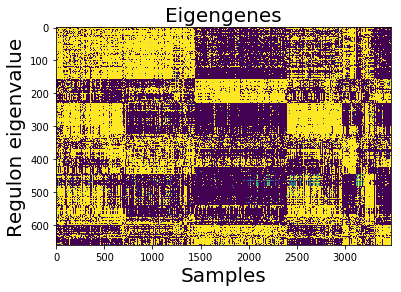

In [37]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

t1 = time.time()
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None,showplot=False)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"))

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=int(np.ceil(0.01*orderedDM.shape[0])),allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

#plot eigengenes
plt.figure()
plt.imshow(eigengenes.loc[np.hstack(program_list),np.hstack(states)],cmap="viridis",vmin=-0.05,vmax=0.05,aspect="auto")
plt.xlabel("Samples",FontSize=20)
plt.ylabel("Regulon eigenvalue",FontSize=20)
plt.title("Eigengenes",FontSize=20)
plt.grid(False)

t2 = time.time()
print("completed subtype inference in {:.2f} minutes".format((t2-t1)/60.))

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))